In [1]:
import json
import logging
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import bif
from custom.functions import CustomMLModel
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.base import BaseTransformer
from iotfunctions.bif import EntityDataGenerator
from custom import settings
import datetime as dt

import pandas as pd
import numpy as np

from watson_machine_learning_client import WatsonMachineLearningAPIClient
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
import sklearn


/Users/kkbankol@us.ibm.com/projects/watson-analytics-dashboard/env/lib/python3.7/site-packages/iotfunctions/bif.py:1945: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'

2020-04-02 22:57:42,066 - root - INFO - 
Logging Set To: DEBUG


Loading WML Environment Variables
Environment Variables Loaded Successfully


In [42]:
# set Monitor credentials here
credentials = {}
db = Database(credentials = credentials)
db_schema = None #  set if you are not using the default



2020-04-02 23:31:54,643 - iotfunctions.db - INFO - 
Connection string for SqlAlchemy => db2): db2+ibm_db://iotanalytics:I0TAnalytics2@2@@dashdb-enterprise-yp-dal12-125.services.dal.bluemix.net:50000/BLUDB;

2020-04-02 23:31:54,643 - iotfunctions.db - INFO - 
Connection string for SqlAlchemy => db2): db2+ibm_db://iotanalytics:I0TAnalytics2@2@@dashdb-enterprise-yp-dal12-125.services.dal.bluemix.net:50000/BLUDB;

2020-04-02 23:31:54,662 - iotfunctions.db - DEBUG - 
created a CosClient object

2020-04-02 23:31:55,459 - iotfunctions.db - DEBUG - 
Db connection established

2020-04-02 23:32:12,116 - iotfunctions.db - DEBUG - 
http request successful. status 200


In [129]:
print("Setting anomaly_score columns to zeros ")
entity_name = 'turbine_demo'
df = db.read_table(table_name=entity_name, schema=db_schema)
df['anomaly_score'] = np.zeros(len(df))
db.write_frame(df, table_name=entity_name, schema=db_schema, if_exists="replace")
db.commit()

Setting anomaly_score columns to zeros 


/Users/kkbankol@us.ibm.com/projects/watson-analytics-dashboard/env/lib/python3.7/site-packages/sqlalchemy/engine/reflection.py:919: SAWarning: index key 'sqlnotapplicable' was not located in columns for table 'turbine_demo'
  "columns for table '%s'" % (flavor, c, table_name)

2020-04-03 00:43:07,573 - iotfunctions.db - INFO - 
Wrote data to table turbine_demo 

2020-04-03 00:43:07,573 - iotfunctions.db - INFO - 
Wrote data to table turbine_demo 


In [132]:
# build custom model locally (user notebook will go here)
# columns = input_columns
columns = ['drvn_t1', 'drvn_t2', 'drvn_p1', 'drvn_p2', 'drvn_flow']
s_df = df.loc[df['asset_id'] == "73001", :][columns]

rows = [list(r) for i,r in s_df.iterrows()]

# create a model (using IsolationForest here with default settings)
clf = IsolationForest()

# place classifier in a sklearn "pipeline"
pipeline = Pipeline( steps = [ ( "classifier", clf ) ] )

# fit data to model pipeline
pipeline.fit(rows)

s_df = df[columns]
rows = [list(r) for i,r in s_df.iterrows()]

# test model
results = pipeline.predict(rows)
s_df.loc[: ,'anomaly_score'] = results
print(s_df.head())

# from collections import Counter
# print(Counter(results))


    drvn_t1   drvn_t2       drvn_p1       drvn_p2     drvn_flow  anomaly_score
0  9.029124  9.029124      3.009708      3.009708  2.799028e+02              1
1  9.029124  9.029124      3.009708      3.009708  2.799028e+02              1
2  9.029124  9.029124  15000.000000  15000.000000  1.395000e+06             -1
3  5.419259  5.419259      1.354815      1.354815  1.273526e+02              1
4  5.419259  5.419259      1.354815      1.354815  1.273526e+02              1


/Users/kkbankol@us.ibm.com/projects/watson-analytics-dashboard/env/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/kkbankol@us.ibm.com/projects/watson-analytics-dashboard/env/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/kkbankol@us.ibm.com/projects/watson-analytics-dashboard/env/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

/Users/kkbankol@us.ibm.com/projects/watson-analytics-dashboard/env/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


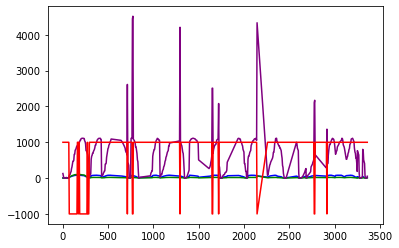

In [138]:
# create plots
# note - devices 73002 73003 are normal. 73001, 73000 have more anomalies


import matplotlib.pyplot as plt
# turbine1 = df.loc[df['anomaly_score'] == 0, :].index
turbine1 = df.loc[df['asset_id'] == "73000", :]
s_df.loc[: ,'anomaly_score'] = results
plt.plot(s_df.iloc[turbine1.index]['drvn_t1'], color='blue', label='drvn_t1')
plt.plot(s_df.iloc[turbine1.index]['drvn_p1'], color='green', label='drvn_p1')
plt.plot(s_df.iloc[turbine1.index]['drvn_flow'], color='purple', label='drvn_flow')
plt.plot(s_df.iloc[turbine1.index]['anomaly_score'] * 1000, color='red', label='anomaly_score')

In [134]:
## publish model

# create WML client
wml_creds_path = '/Users/kkbankol@us.ibm.com/projects/maximo_anomaly/wml_credentials.json'
wml_credentials = json.loads(open(wml_creds_path).read())
client = WatsonMachineLearningAPIClient( wml_credentials )

sk_version = sklearn.__version__
metadata = {
    client.repository.ModelMetaNames.FRAMEWORK_VERSION: 'scikit-learn',
    client.repository.ModelMetaNames.FRAMEWORK_VERSION: sk_version,
    client.repository.ModelMetaNames.NAME: 'anomaly_model',
    client.repository.ModelMetaNames.RUNTIME_NAME: 'python',
    client.repository.ModelMetaNames.RUNTIME_VERSION: '3.6'
}

# upload pipeline 
model_details_inmem = client.repository.store_model( pipeline, meta_props=metadata)
model_id_inmem = model_details_inmem["metadata"]["guid"]
deployment_details_inmem = client.deployments.create( artifact_uid=model_id_inmem, name="anomaly_model" )
deployment_id = deployment_details_inmem["metadata"]["guid"]
model_endpoint_url_inmem = client.deployments.get_scoring_url( deployment_details_inmem )
print("model invocation endpoint: " + model_endpoint_url_inmem)
print("Place below line in .env file like so")
print("WATSON_ML_DEPLOYMENT_ID=" + deployment_id) # TODO, need to confirm notebook will reload .env file. Or just change from .env to mem



2020-04-03 05:32:05,270 - ModelCollection - DEBUG - 
Creating a new scikit pipeline model: anomaly_model

2020-04-03 05:32:06,813 - watson_machine_learning_client.libs.repo.swagger_client.rest - DEBUG - 
response body: {"metadata":{"guid":"aa79f148-ea01-41c5-9f43-83beb0d03119","url":"https://us-south.ml.cloud.ibm.com/v3/ml_assets/models/aa79f148-ea01-41c5-9f43-83beb0d03119","created_at":"2020-04-03T12:32:05.642Z"},"entity":{"name":"anomaly_model","model_url":"/v3/ml_assets/models/aa79f148-ea01-41c5-9f43-83beb0d03119","framework":{"name":"scikit-learn","version":"0.20","runtimes":[{"name":"python","version":"3.6"}]},"model_version":{"url":"https://us-south.ml.cloud.ibm.com/v3/ml_assets/models/aa79f148-ea01-41c5-9f43-83beb0d03119/versions/1356367e-8202-4084-8ddd-142f5ba4fcfc","guid":"1356367e-8202-4084-8ddd-142f5ba4fcfc","content_status":{"state":"no_content"},"hyper_parameters":[],"content_url":"https://us-south.ml.cloud.ibm.com/v3/ml_assets/models/aa79f148-ea01-41c5-9f43-83beb0d03119/



#######################################################################################

Synchronous deployment creation for uid: 'aa79f148-ea01-41c5-9f43-83beb0d03119' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS....

KeyboardInterrupt: 

In [ ]:
from custom.functions import CustomMLModel
db.register_functions([CustomMLModel], force_preinstall=True)

In [137]:
WATSON_ML_ENDPOINT = settings.WATSON_ML_ENDPOINT
WATSON_ML_INSTANCE_ID = settings.WATSON_ML_INSTANCE_ID
WATSON_ML_APIKEY = settings.WATSON_ML_APIKEY
WATSON_ML_DEPLOYMENT_ID = settings.WATSON_ML_DEPLOYMENT_ID

IAM_UID = settings.IAM_UID
IAM_PASSWORD = settings.IAM_PASSWORD

INPUT_COLUMNS = settings.INPUT_COLUMNS or []
if INPUT_COLUMNS and (len(INPUT_COLUMNS) > 0):
    INPUT_COLUMNS = INPUT_COLUMNS.replace(' ', '').split(',')
else:
    INPUT_COLUMNS = []

entity_name = 'turbine_demo'
INPUT_COLUMNS = ['drvn_flow', 'drvn_t1', 'drvn_t2', 'drvn_p1', 'drvn_p2']
WATSON_ML_DEPLOYMENT_ID='69373af1-8fd2-4650-ae35-2d5ebb01d4ae'

entity = EntityType(entity_name, db,
                # following columns can be dynamically generated based on meters associated with each asset
                CustomMLModel(
                                wml_endpoint=WATSON_ML_ENDPOINT,
                                instance_id=WATSON_ML_INSTANCE_ID,
                                deployment_id=WATSON_ML_DEPLOYMENT_ID,
                                apikey=WATSON_ML_APIKEY,
                                input_columns=INPUT_COLUMNS,
                                output_item = 'anomaly_score_output'),
                **{
                  '_timestamp' : 'evt_timestamp',
                  '_db_schema' : db_schema}
)
entity.exec_local_pipeline()



2020-04-03 05:34:18,767 - root - DEBUG - 
body {}

2020-04-03 05:34:18,769 - root - DEBUG - 
column_map {}

2020-04-03 05:34:18,771 - iotfunctions.metadata - DEBUG - 
Initializing new entity type using iotfunctions 2.0.3

2020-04-03 05:34:18,773 - iotfunctions.util - DEBUG - 
Starting trace

2020-04-03 05:34:18,776 - iotfunctions.util - DEBUG - 
Trace name: auto_trace_turbine_demo_20200403123418

2020-04-03 05:34:18,777 - iotfunctions.util - DEBUG - 
auto_save None

2020-04-03 05:34:18,779 - iotfunctions.metadata - WARNING - 
No _db_schema specified in **kwargs. Usingdefault database schema.

2020-04-03 05:34:18,779 - iotfunctions.metadata - WARNING - 
No _db_schema specified in **kwargs. Usingdefault database schema.

2020-04-03 05:34:18,781 - iotfunctions.util - DEBUG - 
categorizing arguments

2020-04-03 05:34:18,782 - iotfunctions.metadata - DEBUG - 
Initialized entity type 
EntityType:TURBINE_DEMO
Functions:
CustomMLModel at granularity None required inputs not evaluated yet outp


2020-04-03 05:34:21,188 - root - DEBUG - 
Index(['deviceid', 'evt_timestamp', 'devicetype', 'logicalinterface_id',
       'eventtype', 'format', 'updated_utc', 'drvn_p1', 'maintenance_status_x',
       'mainteancne_status_y', 'predict_drvn_t1', 'predict_drvn_p1', 'drvn_t2',
       'drvn_p2', 'predict_drvn_t2', 'predict_drvn_p2', 'run_status',
       'scheduled_maintenance', 'unscheduled_maintenance', 'compressor_in_x',
       'compressor_in_y', 'asset_id', 'compressor_out_x', 'drvr_rpm',
       'compressor_out_y', 'drvn_flow', 'run_status_x', 'drvn_t1',
       'run_status_y', 'anomaly_score'],
      dtype='object')

2020-04-03 05:34:21,199 - root - DEBUG - 
posting enitity data to WML model

2020-04-03 05:34:21,943 - root - DEBUG - 
token successfully generated

2020-04-03 05:34:21,945 - root - DEBUG - 
posting to WML

2020-04-03 05:34:21,946 - root - DEBUG - 
filtering columns

2020-04-03 05:34:21,947 - root - DEBUG - 
['drvn_flow', 'drvn_t1', 'drvn_t2', 'drvn_p1', 'drvn_p2']


Index(['deviceid', 'evt_timestamp', 'devicetype', 'logicalinterface_id',
       'eventtype', 'format', 'updated_utc', 'drvn_p1', 'maintenance_status_x',
       'mainteancne_status_y', 'predict_drvn_t1', 'predict_drvn_p1', 'drvn_t2',
       'drvn_p2', 'predict_drvn_t2', 'predict_drvn_p2', 'run_status',
       'scheduled_maintenance', 'unscheduled_maintenance', 'compressor_in_x',
       'compressor_in_y', 'asset_id', 'compressor_out_x', 'drvr_rpm',
       'compressor_out_y', 'drvn_flow', 'run_status_x', 'drvn_t1',
       'run_status_y', 'anomaly_score'],
      dtype='object')
Index(['drvn_flow', 'drvn_t1', 'drvn_t2', 'drvn_p1', 'drvn_p2'], dtype='object')



2020-04-03 05:34:23,701 - root - DEBUG - 
model response code: 200

2020-04-03 05:34:23,702 - root - DEBUG - 
model response

2020-04-03 05:34:23,703 - root - DEBUG - 
{"fields": ["prediction"], "values": [[-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [


2020-04-03 05:34:24,196 - root - DEBUG - 
json

2020-04-03 05:34:24,197 - root - DEBUG - 
{'fields': ['prediction'], 'values': [[-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [


2020-04-03 05:34:24,212 - root - DEBUG - 
results {'fields': ['prediction'], 'values': [[-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1],


2020-04-03 05:34:24,227 - root - DEBUG - 
Generated DF from response_data ===

2020-04-03 05:34:24,231 - root - DEBUG - 
ReMapped DF ===

2020-04-03 05:34:24,234 - root - DEBUG - 
required_cols ['deviceid', 'evt_timestamp', 'devicetype', 'logicalinterface_id', 'eventtype', 'format', 'updated_utc', 'drvn_p1', 'maintenance_status_x', 'mainteancne_status_y', 'predict_drvn_t1', 'predict_drvn_p1', 'drvn_t2', 'drvn_p2', 'predict_drvn_t2', 'predict_drvn_p2', 'run_status', 'scheduled_maintenance', 'unscheduled_maintenance', 'compressor_in_x', 'compressor_in_y', 'asset_id', 'compressor_out_x', 'drvr_rpm', 'compressor_out_y', 'drvn_flow', 'run_status_x', 'drvn_t1', 'run_status_y', 'anomaly_score']

2020-04-03 05:34:24,235 - root - DEBUG - 
missing_cols []

2020-04-03 05:34:24,239 - root - DEBUG - 
DF stripped to only required columns ===

2020-04-03 05:34:24,240 - root - DEBUG - 
     deviceid              evt_timestamp devicetype logicalinterface_id  \
0       73001 2020-04-01 01:42:24.919953 

updated scores
3265    1
3266    1
3267   -1
3268    1
3269    1
       ..
3360   -1
3361   -1
3362   -1
3363   -1
3364   -1
Name: anomaly_score, Length: 100, dtype: int64


/Users/kkbankol@us.ibm.com/projects/watson-analytics-dashboard/env/lib/python3.7/site-packages/sqlalchemy/engine/reflection.py:919: SAWarning: index key 'sqlnotapplicable' was not located in columns for table 'turbine_demo'
  "columns for table '%s'" % (flavor, c, table_name)

2020-04-03 05:34:29,807 - iotfunctions.db - INFO - 
Wrote data to table turbine_demo 

2020-04-03 05:34:29,807 - iotfunctions.db - INFO - 
Wrote data to table turbine_demo 

2020-04-03 05:34:29,813 - root - DEBUG - 
write_frame complete

2020-04-03 05:34:29,820 - custom.functions - DEBUG - 
Wrote data to table

2020-04-03 05:34:29,823 - root - DEBUG - 
appended trace

2020-04-03 05:34:29,829 - iotfunctions.system_function - DEBUG - 
Skipping empty dataframe received as merge input

2020-04-03 05:34:29,833 - iotfunctions.pipeline - INFO - 
Trace message:  Completed stage.

2020-04-03 05:34:29,833 - iotfunctions.pipeline - INFO - 
Trace message:  Completed stage.

2020-04-03 05:34:29,836 - iotfunctions.pipeline - I

ConnectionError: HTTPSConnectionPool(host='undefined', port=443): Max retries exceeded with url: /analytics-runtime-monitor-demo-395729cb6a06/Monitor-Demo/turbine_demo/20200403/turbine_demo_trace_123418 (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x12ba0e310>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

In [ ]:
'''











'''



In [ ]:
entity = EntityType('kb_anomaly', db,
                    Column('deviceid',String(50)),
                    Column('anomaly_score', Integer()),
                    Column("torque", Integer()),
                    Column("acc", Integer()),
                    Column("load", Integer()),
                    Column("tool_type", Integer()),
                    Column("speed", Float()),
                    Column("travel_time", Float()),
                    **{
                      '_timestamp' : 'evt_timestamp',
                      # '_production_mode': False,
                      '_db_schema' : db_schema}
)

entity.register(raise_error=False)

In [3]:
# df = pd.read_csv('/Users/kkbankol@us.ibm.com/projects/maximo_anomaly/kb_anomaly_dump.csv')
df = db.read_table(table_name='Equipment', schema=db_schema)
df.head()
df['devicetype'] = "Turbines"
# df.head()
df.to_csv('/Users/kkbankol@us.ibm.com/projects/maximo_anomaly/equipment_dump.csv')


2020-04-02 22:58:28,414 - iotfunctions.db - DEBUG - 
<module 'custom.functions' from '/Users/kkbankol@us.ibm.com/projects/maximo_anomaly/custom/functions.py'> is preinstalled False

2020-04-02 22:58:28,415 - iotfunctions.base - DEBUG - 
Looking for item values for {'name': 'wml_endpoint', 'type': 'CONSTANT', 'dataType': 'LITERAL', 'description': 'Endpoint to WML service where model is hosted', 'tags': ['TEXT'], 'required': True, 'values': None}

2020-04-02 22:58:28,416 - iotfunctions.base - DEBUG - 
Looking for item values for {'name': 'instance_id', 'type': 'CONSTANT', 'dataType': 'LITERAL', 'description': 'Instance ID for WML model', 'tags': ['TEXT'], 'required': True, 'values': None}

2020-04-02 22:58:28,417 - iotfunctions.base - DEBUG - 
Looking for item values for {'name': 'deployment_id', 'type': 'CONSTANT', 'dataType': 'LITERAL', 'description': 'Deployment ID for WML model', 'tags': ['TEXT'], 'required': True, 'values': None}

2020-04-02 22:58:28,418 - iotfunctions.base - DEBUG

''

In [139]:
wml_credentials

{'apikey': 'rRjjtJevY3Hk9X7lD3tC8ay6xkBJmTiIT_oKJkCaVLKe',
 'iam_apikey_description': 'Auto-generated for key 42841805-1acb-4363-9b91-01879debc973',
 'iam_apikey_name': 'Service credentials-1',
 'iam_role_crn': 'crn:v1:bluemix:public:iam::::serviceRole:Writer',
 'iam_serviceid_crn': 'crn:v1:bluemix:public:iam-identity::a/f65bf29af08809df5174fedfe7bf9d3b::serviceid:ServiceId-2e8b108b-d201-4a45-a33b-4d306210e574',
 'instance_id': 'da1a8e1e-84bd-483d-bf4d-14f43b3b7a51',
 'url': 'https://us-south.ml.cloud.ibm.com'}

In [ ]:
# generate simulation data
## if we want to use simulation data, run following. this will also create 5 sample entity instances
entity_name = 'kb_anomaly'
print("Generating sample data for " + entity_name)
entity.generate_data(days=2.0, drop_existing=True)


In [ ]:
df = pd.read_csv('/Users/kkbankol@us.ibm.com/projects/maximo_anomaly/equipment_dump.csv')
df['deviceid'].unique()

unscored_rows_idx = df.loc[df['anomaly_score'] == 0, :].index
df.iloc[unscored_rows_idx]
# df.columns

# write data to disk
# entity_name = 'Equipment'
# open(entity_name + '_dump.csv', 'w+').write(df.to_csv())

In [ ]:

## create and register entity
## only required if entity does not exist already
if settings.ENTITY_NAME:
    entity_name = settings.ENTITY_NAME

if settings.INPUT_COLUMNS:
    input_columns = settings.INPUT_COLUMNS.replace(' ', '').split(',')

# if settings.OUTPUT_COLUMNS:
#     output_columns = settings.OUTPUT_COLUMNS.replace(' ', '').split(',')
# else:
#     # defaulting
#     output_columns = [Column('anomaly_score',Integer, default=0)]




entity_columns = [Column('anomaly_score',Integer(), default=0)] + list(map(lambda x: Column(x, Float()), input_columns))  #   Column('anomaly_score', Integer()))

print(entity_columns)

entity_name = "kb_anomaly_test1"
print("creating entity: " + entity_name)

entity = EntityType(entity_name, db,
                    *entity_columns,
                    **{
                      '_timestamp' : 'evt_timestamp',
                      '_db_schema' : db_schema}
                   )
print("Registering entity")
entity.register()
print("Entity registered")

# entity.generate_data(days=2.0, drop_existing=True)




In [ ]:

# reduce entity dataframe to relevant input columns
if settings.INPUT_COLUMNS:
    columns = (settings.INPUT_COLUMNS).split(', ')
else:
    columns = []

    
columns = ['drvn_flow', 'drvn_t1', 'drvn_t2', 'drvn_p1', 'drvn_p2']

if len(columns) > 0:
    print("filtering columns")
    print(columns)
    s_df = df[columns]
else:
    print("using original dataframe")
    s_df = df

print(s_df.head())

# convert dataframe to 2d array (as expected by WML)
rows = [list(r) for i,r in s_df.iterrows()]
